In [1]:
import numpy as np
import pylab as plt

c = 299792458. # m/s
np.random.seed(42)
sqrttwopi = np.sqrt(2. * np.pi)

# Borrowing code from EPRV to make fake data + template:

In [2]:
def doppler(rv):
    beta = rv / c
    return np.sqrt((1. - beta) / (1. + beta))

def oned_gaussian(xs, mm, sig):
    return np.exp(-0.5 * (xs - mm) ** 2 / sig ** 2) / (sqrttwopi * sig)

def make_synth(rv, xs, ds, ms, sigs):
    """
    Generate a noiseless synthetic spectrum at given rv shift.
    `rv`: radial velocity in m/s (or same units as `c` above)
    `xs`: `[M]` array of wavelength values
    `ds`: depths at line centers
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    --
    We take the view that lines multiply into the spectrum.
    """
    lnsynths = np.zeros_like(xs)
    for d, m, sig in zip(ds, ms, sigs):
        lnsynths += (d * oned_gaussian(xs * doppler(rv), m, sig))
    return np.exp(lnsynths)

def make_data(N, xs, ds, ms, sigs, snr):
    """
    Generate a set of N synthetic spectra.
    `N`: number of spectra to make
    `xs`: `[M]` array of wavelength values
    `ds`: depth-like parameters for lines
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    `snr`: desired SNR per pixel
    """
    M = len(xs)
    data = np.zeros((N, M))
    ivars = np.zeros((N, M))
    rvs = 30000. * np.random.uniform(-1., 1., size=N) # 30 km/s bc Earth ; MAGIC
    for n, rv in enumerate(rvs):
        ivars[n, :] = snr**2.
        data[n, :] = make_synth(rv, xs, ds, ms, sigs)
        data[n, :] += np.random.normal(size=M) / np.sqrt(ivars[n, :])
    return data, ivars, rvs

In [3]:
fwhms = np.asarray([0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879]) # FWHM of Gaussian fit to line (A)
sigs = fwhms / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = np.asarray([4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87]) # line center (A)
cs = np.asarray([-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536]) # contrast (normalized flux)
ds = np.log(1. + cs) * sigs * sqrttwopi # trust us
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
snr = 100.

N = 64
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs, snr)

In [4]:
data_xs = np.tile(xs, (N,1))


In [5]:
template_xs = np.arange(4997. + 0.5 * dx, 5003., dx) # A
template = make_synth(0.0, template_xs, ds, ms, sigs)
template += np.random.normal(size=len(template_xs)) / 500. # SNR = 500

Text(0,0.5,'Normalized Flux')

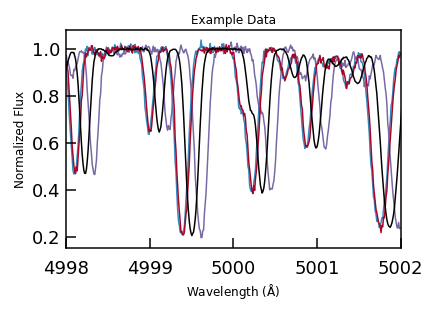

In [6]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n])
plt.plot(template_xs, template, color='k')
plt.xlim([4998.,5002.])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux')

# now solve for RVs with tensorflow:

In [7]:
from wobble.interp import interp
import tensorflow as tf
T = tf.float64

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return tf.sqrt(frac)

In [9]:
model_xs_tensor = tf.constant(np.log(template_xs), dtype=T)
model_ys_tensor = tf.Variable(np.log(template), dtype=T)
data_tensor = tf.constant(np.log(data), dtype=T)
xs_tensor = tf.constant(np.log(data_xs), dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

In [10]:
starting_rvs = true_rvs + np.random.normal(0., 100., len(true_rvs))
rvs_tensor = tf.Variable(starting_rvs, dtype=T)

In [11]:
nll = tf.constant(0.0, dtype=T)
models = []
for n in range(len(data)):
    shifted_xs = xs_tensor[n] + tf.log(doppler(rvs_tensor[n]))
    model = interp(shifted_xs, model_xs_tensor, model_ys_tensor)
    models.append(model)
    nll += 0.5*tf.reduce_sum((data_tensor[n] - model)**2 * ivars_tensor[n])
    
grad_model = tf.gradients(nll, [model_ys_tensor])[0] + tf.zeros_like(model_ys_tensor)
grad_rvs = tf.gradients(nll, [rvs_tensor])[0] + tf.zeros_like(rvs_tensor)

In [12]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    models_eval = session.run(models)

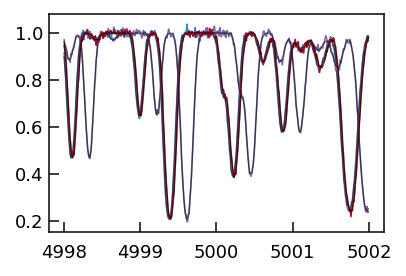

In [13]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n])
    plt.plot(data_xs[n], np.exp(models_eval[n]), color='k', alpha=0.5)

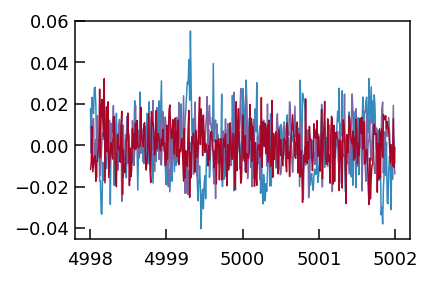

In [14]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n] - np.exp(models_eval[n]))

In [29]:
opt_rvs = tf.train.AdagradOptimizer(100.).minimize(nll, var_list=rvs_tensor)

In [30]:
session = tf.Session()
session.run(tf.global_variables_initializer())

nll_after_rvs = []
for i in range(100):
    session.run(opt_rvs)
    nll_after_rvs.append(session.run(nll))

params_rvs = session.run(rvs_tensor)
model_ys = session.run(model_ys_tensor)
models_eval = session.run(models)

1699.681014754904


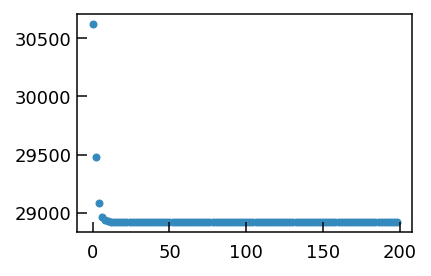

In [31]:
plt.scatter(np.arange(len(nll_after_rvs))*2, nll_after_rvs)
print nll_after_rvs[0] - nll_after_rvs[-1]

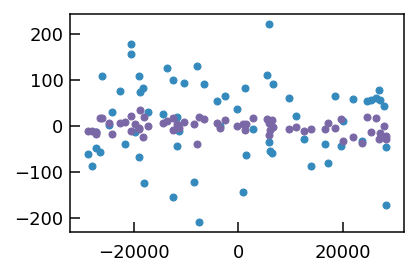

In [32]:
plt.scatter(true_rvs, starting_rvs - true_rvs)
plt.scatter(true_rvs, params_rvs - true_rvs)

In [33]:
np.std(params_rvs - true_rvs)

15.713716966606713

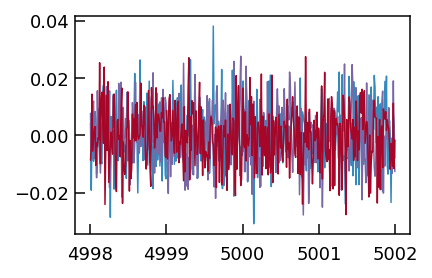

In [34]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n] - np.exp(models_eval[n]))